In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn as sns
import RA_funcs as rf


imports work


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Telescope

In [117]:
# Telescope merge
import pandas as pd
import gc

def process_single_file_awkward_vectorized(run_number):
    f = uproot.open(f"TB_FIRE/TB_reco/TB_FIRE_{run_number}_raw_reco.root")
    tele = uproot.open(f"TB_FIRE/TB_reco/run_{run_number}_telescope.root")

    arrs_events = f["Hits"].arrays(["TLU_number", "amplitude", "plane_ID", "ch_ID"], library="ak")
    tele_events = tele["TrackingInfo/Tracks"].arrays(["triggerid", "x_dut", "y_dut"], library="ak")

    arrs_events.TLU_number

    df_dut = pd.DataFrame({
        "TLU": ak.to_list(np.sort(arrs_events.TLU_number)),
        "amplitude": ak.to_list(arrs_events.amplitude),
        "plane_ID": ak.to_list(arrs_events.plane_ID),
        "ch_ID": ak.to_list(arrs_events.ch_ID)
    })

    nonempty_mask = (ak.num(tele_events["x_dut"]) == 1) & (ak.num(tele_events["y_dut"]) == 1)
    
    tele_trig_filtered = tele_events["triggerid"][nonempty_mask]
    tele_x_filtered    = tele_events["x_dut"][nonempty_mask]
    tele_y_filtered    = tele_events["y_dut"][nonempty_mask]

    flat_triggers = ak.to_list(ak.flatten(tele_trig_filtered, axis=None))
    flat_x        = ak.to_list(ak.flatten(tele_x_filtered, axis=None))
    flat_y        = ak.to_list(ak.flatten(tele_y_filtered, axis=None))

    df_tele = pd.DataFrame({
        "triggerid": np.sort(flat_triggers),
        "x_dut": flat_x,
        "y_dut": flat_y
    })
   
    print("DataFrames constructed.")

    df_tele = df_tele[df_tele["triggerid"].isin(df_dut["TLU"])]
    df_dut = df_dut[df_dut["TLU"].isin(df_tele["triggerid"])]
    
    # Group DUT hits by TLU
    grouped_dut = df_dut.groupby("TLU", sort=False).agg({
        "amplitude": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])],
        "plane_ID": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])],
        "ch_ID": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])]
    }).reset_index()

    # Group telescope hits by triggerid
    grouped_tele = df_tele.groupby("triggerid", sort=False).agg({
        "x_dut": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])],
        "y_dut": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])]
    }).reset_index().rename(columns={"triggerid": "TLU"})


    print("DataFrames grouped by TLU/triggerid")
    # Merge DUT and telescope on TLU
    merged = pd.merge(grouped_dut, grouped_tele, on="TLU", how="left")

    print("DataFrames merged")

    del flat_triggers, flat_x, flat_y, df_dut, df_tele, grouped_dut, grouped_tele
    gc.collect()

    print("collected garbage")

    events_awk = ak.zip({
        # "TLU": ak.Array(merged["TLU"].tolist()),
        "plane": ak.Array(merged["plane_ID"].tolist()),
        "ch": ak.Array(merged["ch_ID"].tolist()),
        "amp": ak.Array(merged["amplitude"].tolist()),
        "x": ak.flatten(ak.Array(merged["x_dut"].tolist()),axis=1),
        "y": ak.flatten(ak.Array(merged["y_dut"].tolist()),axis=1)
    })

    return events_awk


In [118]:
b = process_single_file_awkward_vectorized(1093)

DataFrames constructed.
DataFrames grouped by TLU/triggerid
DataFrames merged
collected garbage


In [119]:
b

<Array [[{plane: 0, ch: 101, ...}, ...], ...] type='440918 * var * {plane: ...'>

In [140]:
# a function that get 2 arrays, and groups them by categories of the first 1, returns the grouped data and the classes(categories)
def ak_groupby_for_scope(classes, data):
    

    # zip the arrays
    zipped_arrays = ak.zip({ "classes":classes, "data":data} ,depth_limit=1)

    # sort by classes
    data_classes_sorted = zipped_arrays[ak.argsort(zipped_arrays.classes)]

    # divide to subarrays by classes
    lengths = ak.run_lengths(data_classes_sorted.classes)

    # return lengths, data_classes_sorted
    data_by_class_divided = ak.unflatten(data_classes_sorted, lengths)

    # get the classes list
    reduced_classes = data_by_class_divided.classes[..., 0]


    # return data_by_class_divided 
    return data_by_class_divided, reduced_classes





# Merge DUT and Telescope Data
def DUT_TELE_merge(run_number):

    # read DUT
    dut = uproot.open(f"TB_FIRE/TB_reco/TB_FIRE_{run_number}_raw_reco.root")
    hits = dut['Hits']
    TLU = hits['TLU_number'].array()
    plane = hits['plane_ID'].array()
    channel = hits['ch_ID'].array()
    amp = hits['amplitude'].array()
    hit_data = ak.zip({ "plane":plane, "ch":channel, "amp":amp})

    # sort DUT data to have a single TLU per event

    TLU_data, TLU = ak_groupby_for_scope(TLU,hit_data)
    single_TLU_data = TLU_data[ak.num(TLU_data) == 1]
    single_TLU_data = single_TLU_data[ak.num(single_TLU_data) > 0]
    
    # read tele
    tele = uproot.open(f"TB_FIRE/TB_reco/run_{run_number}_telescope.root")
    tracks = tele['TrackingInfo']['Tracks']
    trigID = tracks['triggerid'].array()
    chi2_ndof = tracks['chi2'].array() / tracks['ndof'].array()
    x = tracks['x_dut'].array()
    y = tracks['y_dut'].array()
    tele_data = ak.zip({"x":x, "y":y, "chired":chi2_ndof})

    # sort TELE data by trigger ID
    trigID_data, trigID = ak_groupby_for_scope(ak.flatten(trigID), tele_data)
    
    # events with 1 triger ID
    single_trigID = trigID_data[ak.num(trigID_data) == 1]

    # events with one telescope track only
    single_track_with_zeros = single_trigID[ak.num(single_trigID.data, axis = 2) == 1]
    single_track_data = single_track_with_zeros[ak.num(single_track_with_zeros) > 0]

    # create mask to get only data with TLU and trigger ID by substraction
    print(single_TLU_data.classes)
    print(single_track_data.classes)

    # get indices for events that with matching TLU and TriggerID
    single_TLU_index = single_TLU_data.classes
    single_track_index = single_track_data.classes
    mask_dut = np.isin(single_TLU_index, single_track_index)
    mask_tele = np.isin(single_track_index, single_TLU_index)

    # get the data from dut and tele for corresponding events (apply mask)
    final_dut_data = single_TLU_data[mask_dut]
    final_tele_data = single_track_data[mask_tele]

    # combine DUT and TELE data
    final_dut_hit_data = final_dut_data.data
    final_tele_fit_data = final_tele_data.data
    # return final_dut_hit_data, final_tele_fit_data
    print(len(final_dut_hit_data))
    print(len(final_tele_fit_data))
    merged = ak.zip({"hits":final_dut_hit_data, "tele":final_tele_fit_data},depth_limit=1)

    return merged

In [142]:
a = DUT_TELE_merge(1093)

[[0], [1], [2], [3], [4], ..., [500617], [500618], [500619], [500620], [500621]]
[[1], [2], [3], [4], [5], ..., [500613], [500614], [500615], [500616], [500617]]
440902
440902


In [147]:
a.hits

<Array [[{plane: 0, ch: 101, ...}, ...], ...] type='440902 * var * {plane: ...'>

In [139]:
b[0]

<Array [{x: 8.81, y: -4.99, chired: 1.06}] type='1 * {x: float64, y: float6...'>

In [99]:
import numpy as np

a = ak.Array([1, 2, 3])
b = ak.Array([2, 3, 4, 5])

mask_a = np.isin(a, b)
mask_b = np.isin(b, a)

print(mask_a)  # [False  True  True]
print(mask_b)  # [ True  True False False]


[False, True, True]
[True, True, False, False]


In [ ]:
tele = uproot.open(f"TB_FIRE/TB_reco/run_{1093}_telescope.root")
tracks = tele['TrackingInfo']['Tracks']

trigID = tracks['triggerid'].array()
chi2_ndof = tracks['chi2'].array() / tracks['ndof'].array()
x = tracks['x_dut'].array()
y = tracks['y_dut'].array()
tele_data = ak.zip({"x":x, "y":y, "chired":chi2_ndof})

In [53]:
x
trigID[ak.num(trigID) > 1]
x[ak.num(x) > 1]

<Array [[-11.1, -0.326], ..., [-2.74, 2.97]] type='39485 * var * float64'>

In [79]:
a,b = ak_groupby_for_scope(ak.flatten(trigID), tele_data)
a[ak.num(a) > 1]
b = a[ak.num(a.data, axis = 2) == 1]
b[ak.num(b)>0]

<Array [[{classes: 1, data: ..., ...}], ...] type='440922 * var * {classes:...'>

In [26]:
# read DUT and TELE files
run_number = 1093

dut = uproot.open(f"TB_FIRE/TB_reco/TB_FIRE_{run_number}_raw_reco.root")
tele = uproot.open(f"TB_FIRE/TB_reco/run_{run_number}_telescope.root")

In [27]:
hits = dut['Hits']
TLU = hits['TLU_number'].array()
plane = hits['plane_ID'].array()
channel = hits['ch_ID'].array()
amp = hits['amplitude'].array()
hit_data = ak.zip({ "plane":plane, "ch":channel, "amp":amp})


In [28]:
TLU

<Array [0, 1, 2, 3, ..., 500618, 500619, 500620, 500621] type='500633 * uint64'>

In [125]:
zipped_arrays = ak.zip({ "TLU":TLU, "hit_data":hit_data} ,depth_limit=1)
zipped_arrays[zipped_arrays.TLU == 55439]

<Array [{TLU: 55439, hit_data: ..., ...}, ...] type='2 * {TLU: uint64, hit_...'>

In [102]:
# a function that get 2 arrays, and groups them by categories of the first 1, returns the grouped data, mean of data for each group, and the classes(categories)
def ak_groupby_for_scope(classes, data, round = "false"):
    
    # round the values
    if round == "true":
        classes = ak.round(classes)

    # zip the arrays
    zipped_arrays = ak.zip({ "classes":classes, "data":data} ,depth_limit=1)

    # sort by classes
    data_classes_sorted = zipped_arrays[ak.argsort(zipped_arrays.classes)]

    # divide to subarrays by classes
    lengths = ak.run_lengths(data_classes_sorted.classes)

    # return lengths, data_classes_sorted
    data_by_class_divided = ak.unflatten(data_classes_sorted, lengths)

    # get the classes list
    reduced_classes = data_by_class_divided.classes[..., 0]


    # return data_by_class_divided 
    return data_by_class_divided, reduced_classes



In [71]:
a,b = ak_groupby_for_scope(TLU,hit_data)
a = a[ak.num(a) > 1]
a[ak.num(a) > 0]
# a = a[a.classes == 55439]
# a[ak.num(a)>0]

<Array [[{classes: 55439, ...}, ...], ...] type='17 * var * {classes: uint6...'>

In [84]:
ak.zip({ "TLU":TLU, "channel":ak.mean(channel)})
# ak.zip({ "TLU":TLU, "channel":channel})

<Array [{TLU: 0, channel: 131}, ..., {...}] type='500633 * {TLU: uint64, ch...'>

In [79]:
channel

<Array [[147, 146, 147, ..., 127, 166, 167], ...] type='500633 * var * int32'>

In [ ]:
# ak_groupby(TLU,ak.mean(channel, axis = 1))
lengths, sorted_data = ak_groupby(TLU,TLU*10)
sorted_data

[{classes: 0, data: 0}, {...}, ..., {...}, {classes: 500621, data: 5006210}]


<Array [{classes: 0, data: 0}, ..., {...}] type='500633 * {classes: uint64,...'>

[{classes: 0, data: [147, 146, ..., 167]}, {...}, ..., {classes: 500621, ...}]
[[{classes: 0, data: [147, 146, ..., 167]}], ..., [{classes: 500621, ...}]]


<Array [[{classes: 0, data: [...]}], ...] type='500616 * var * {classes: ui...'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Open Root File

In [4]:
# load root file

infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'
infile = uproot.open(infile_name)

<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_5860\3738565995.py:3: SyntaxWarning: invalid escape sequence '\T'
  infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Get the Dead Channels list

In [6]:
# # get headings

# print(type(infile))
# keys = infile.keys()
# print(keys)

# diagnostics = infile['Diagnostics;1']
# print(type(diagnostics))
# # diagnostics.show()

In [12]:
# expand branches within headings(keys) 

# branches = infile['Hits'].keys()
branches = diagnostics.keys()

for branch in branches:
    print(f"{branch:20s} {infile['Diagnostics;1'][branch]}")

# extract specific branch
pt = infile['Diagnostics;1']['BadChannelResults']
pt.keys()

h_decoded_plane_occupancy;1 <TH1D (version 3) at 0x019ee6d1b4d0>
h_reco_plane_occupancy;1 <TH1D (version 3) at 0x019ee7809d10>
TimestampDiagnostics;1 <ReadOnlyDirectory '/Diagnostics/TimestampDiagnostics' at 0x019ee6dd0190>
TimestampDiagnostics/c_tlu_vs_ts;1 <Unknown TCanvas at 0x019ee78052b0>
BadChannelResults;1  <TTree 'BadChannelResults' (6 branches) at 0x019ee7805400>


['planeID', 'channelID', 'mean', 'std_dev', 'std_dev_postprocessed', 'isGood']

In [39]:
isgood = infile['Diagnostics;1']['BadChannelResults']['isGood']
isgood_arr = ak.Array(isgood.array())
isgood_planes = ak.unflatten(isgood_arr, 256)
isgood_planes

<Array [[True, True, True, ..., False, True, True], ...] type='8 * 256 * bool'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Read Data In Root File Using Awkward

In [8]:
# load root file

infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'
infile = uproot.open(infile_name)

# get headings

print(type(infile))
keys = infile.keys()
print(keys)

hits = infile['Hits']
print(type(hits))

<class 'uproot.reading.ReadOnlyDirectory'>
['Hits;1', 'BadChannelResults;1', 'SignalPulses;1']
<class 'uproot.models.TTree.Model_TTree_v20'>


<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_22432\13849479.py:3: SyntaxWarning: invalid escape sequence '\T'
  infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'


In [9]:
# sort all the characters of the run in arrays
tlu = hits['TLU_number'].array()
amp = hits['amplitude'].array()
toa = hits['toa'].array()
time = hits['timestamp'].array()
plane = hits['plane_ID'].array()
channel = hits['ch_ID'].array()

In [10]:
tlu

<Array [0, 1, 2, 3, ..., 503030, 503031, 503032, 503033] type='503069 * uint64'>

In [11]:
np.unique(tlu)

<Array [0, 1, 2, 3, ..., 503030, 503031, 503032, 503033] type='503033 * uint64'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">
Deal with events and hits

In [10]:
# print some important characterisics and and present the data for different events
# notice that all arrays are of the same length
print(len(tlu))
print(tlu[10:20],"\n", amp[10:20],"\n", plane[10:20],"\n", channel[10:20])

2356797
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
 [[35, 132, 85, 65, 247, 154, 150, 90, ..., 30, 36, 35, 291, 28, 22, 34], ...] 
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..., 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7], ...] 
 [[5, 104, 121, 122, 124, 125, 144, ..., 164, 185, 143, 144, 164, 143, 144], ...]


In [11]:
# look at a single event
print(len(amp[10]),'\n',len(plane[10]),"\n",len(channel[10]))
print(tlu[10],"\n amplitude:", amp[10],"\n plane", plane[10],"\n channel", channel[10])

41 
 41 
 41
10 
 amplitude: [35, 132, 85, 65, 247, 154, 150, 90, 44, ..., 83, 30, 36, 35, 291, 28, 22, 34] 
 plane [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..., 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7] 
 channel [5, 104, 121, 122, 124, 125, 144, 145, ..., 164, 185, 143, 144, 164, 143, 144]


In [12]:
# create characteristic string for every hit in the run
hit_data = ak.zip({ "plane":plane, "ch":channel, "amp":amp})
hit_data.show()

[[{plane: 0, ch: 128, amp: 39}, {...}, ..., {plane: 7, ch: 164, amp: 155}],
 [{plane: 0, ch: 126, amp: 13}, {...}, ..., {plane: 6, ch: 184, amp: 28}],
 [{plane: 0, ch: 166, amp: 17}, {...}, ..., {plane: 7, ch: 186, amp: 89}],
 [{plane: 0, ch: 164, amp: 87}, {...}, ..., {plane: 7, ch: 184, amp: 130}],
 [{plane: 0, ch: 102, amp: 50}, {...}, ..., {plane: 7, ch: 163, amp: 83}],
 [{plane: 0, ch: 120, amp: 21}, {...}, ..., {plane: 7, ch: 165, amp: 230}],
 [{plane: 0, ch: 105, amp: 52}, {...}, ..., {plane: 7, ch: 145, amp: 168}],
 [{plane: 0, ch: 144, amp: 12}, {...}, ..., {plane: 7, ch: 167, amp: 23}],
 [{plane: 0, ch: 125, amp: 35}, {...}, ..., {plane: 7, ch: 166, amp: 117}],
 [{plane: 0, ch: 87, amp: 17}, {...}, ..., {...}, {plane: 7, ch: 145, amp: 32}],
 ...,
 [{plane: 5, ch: 169, amp: 21}, {...}, ..., {plane: 6, ch: 183, amp: 248}],
 [{plane: 5, ch: 28, amp: 164}, {...}, ..., {plane: 6, ch: 203, amp: 16}],
 [{plane: 5, ch: 70, amp: 52}, {plane: 5, ch: 165, amp: 175}],
 [{plane: 5, ch: 12

In [13]:
# create triplets of for each hit for a specific TLU
triplets = ak.zip({"amp":amp[10], "plane":plane[10], "ch":channel[10]}).show()
# triplets = ak.zip([amp[10], plane[10], channel[10]]).show()


[{amp: 35, plane: 0, ch: 5},
 {amp: 132, plane: 0, ch: 104},
 {amp: 85, plane: 0, ch: 121},
 {amp: 65, plane: 0, ch: 122},
 {amp: 247, plane: 0, ch: 124},
 {amp: 154, plane: 0, ch: 125},
 {amp: 150, plane: 0, ch: 144},
 {amp: 90, plane: 0, ch: 145},
 {amp: 44, plane: 0, ch: 164},
 {amp: 11, plane: 1, ch: 123},
 ...,
 {amp: 107, plane: 5, ch: 125},
 {amp: 83, plane: 5, ch: 143},
 {amp: 30, plane: 5, ch: 164},
 {amp: 36, plane: 5, ch: 185},
 {amp: 35, plane: 6, ch: 143},
 {amp: 291, plane: 6, ch: 144},
 {amp: 28, plane: 6, ch: 164},
 {amp: 22, plane: 7, ch: 143},
 {amp: 34, plane: 7, ch: 144}]


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">
Introducing "Awkward" library

[39, 27, 183, 73, 435, 83, 38, 63, 32, ..., 70, 56, 107, 53, 356, 61, 29, 67]


Text(0, 0.5, 'Counts')

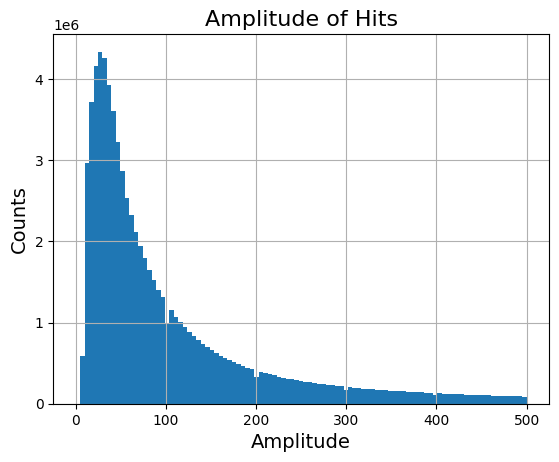

In [24]:
# creating an hitsogram using ak flattening



print(ak.flatten(amp))
plt.figure()
plt.hist(ak.flatten(amp),bins=101,range=(0,500))
# plt.hist(ak.flatten(amp),bins=100)
plt.grid()
plt.title('Amplitude of Hits',fontsize=16)
plt.xlabel('Amplitude',fontsize=14)
plt.ylabel('Counts',fontsize=14)


In [15]:
# use awkward to show all compbinations (permutations) to organize elements from an array in n sized list
a = ak.Array([1,2,3,4,5])
n = 3
ak.combinations(a, n, axis=0).show()

print()

# can also work simultaneousley on different sized sub arrays
b = ak.Array([[1,2,3,4], [20,40,50], [5,6], []])
ak.combinations(b, n).show()

[(1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5)]

[[(1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)],
 [(20, 40, 50)],
 [],
 []]


In [16]:
# create a set of values (x and y)
c = ak.Array([[1,2,3],[40,50]])
ak.combinations(c, 2, fields=["x", "y"]).show()

[[{x: 1, y: 2}, {x: 1, y: 3}, {x: 2, y: 3}],
 [{x: 40, y: 50}]]


In [17]:
# unzip on awkward
numbers = ak.Array([[1, 2, 3], [], [5, 7], [11]])
letters = ak.Array([["a", "b"], ["c"], ["d"], ["e", "f"]])
notes = ak.Array([["la", "mi"], ["ci"], ["do"], ["re", "fa"]])

trios = ak.cartesian((numbers, letters,notes))
# print(trios)
trios.show()
print()

numbers,letters,notes = ak.unzip(trios)
print(numbers)
print()
print(letters)
print()
print(notes)


[[(1, 'a', 'la'), (1, 'a', 'mi'), (...), ..., (3, 'b', 'la'), (3, 'b', 'mi')],
 [],
 [(5, 'd', 'do'), (7, 'd', 'do')],
 [(11, 'e', 're'), (11, 'e', 'fa'), (11, 'f', 're'), (11, 'f', 'fa')]]

[[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], [], [5, 7], [11, 11, 11, 11]]

[['a', 'a', 'b', 'b', 'a', 'a', 'b', 'b', 'a', 'a', 'b', 'b'], ..., ['e', ...]]

[['la', 'mi', 'la', 'mi', 'la', 'mi', ..., 'mi', 'la', 'mi', 'la', 'mi'], ...]


In [18]:
ak.zip({"number":numbers,"letter":letters,"note":notes}).show()
print()
ak.zip([numbers,letters,notes]).show()

[[{number: 1, letter: 'a', note: 'la'}, ..., {number: 3, letter: 'b', ...}],
 [],
 [{number: 5, letter: 'd', note: 'do'}, {number: 7, letter: 'd', ...}],
 [{number: 11, letter: 'e', note: 're'}, ..., {number: 11, letter: 'f', ...}]]

[[(1, 'a', 'la'), (1, 'a', 'mi'), (...), ..., (3, 'b', 'la'), (3, 'b', 'mi')],
 [],
 [(5, 'd', 'do'), (7, 'd', 'do')],
 [(11, 'e', 're'), (11, 'e', 'fa'), (11, 'f', 're'), (11, 'f', 'fa')]]


In [19]:
one = ak.Array([[1.1, 2.2, 3.3], [], [4.4, 5.5], [6.6],])
two = ak.Array([["a", "b", "c"], [], ["d", "e"], ["f"]])


In [20]:
three = ak.Array([100,200,300,400])
ak.zip([one,two,three]).show()

[[(1.1, 'a', 100), (2.2, 'b', 100), (3.3, 'c', 100)],
 [],
 [(4.4, 'd', 300), (5.5, 'e', 300)],
 [(6.6, 'f', 400)]]


In [21]:
three = ak.Array([[],200,300,400])
ak.zip([one,two,three],depth_limit=1).show()

[([1.1, 2.2, 3.3], ['a', 'b', 'c'], []),
 ([], [], 200),
 ([4.4, 5.5], ['d', 'e'], 300),
 ([6.6], ['f'], 400)]
